**Repeated observations within units**

What is the impact of having a heirarchical model on the coefficients of other predictor variables.

 How to deal with repeated observations from the same patient?

In [1]:
import arviz as az
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit, logit
from scipy.optimize import curve_fit
import statsmodels.api as sm
import daft
from causalgraphicalmodels import CausalGraphicalModel
%matplotlib inline

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95  # sets default credible interval used by arviz

sns.set_context("talk")

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Questions

Given known amount of data (each with 1000 rows).

Intercept only model
- Each observation from a different patient
- The same observation from a smaller number of patients
    - Fixed prior
    - Adaptive prior


Intercept + one predictor
- Each observation from a different patient
- The same observation from a smaller number of patients
    - Fixed prior on intercept, fixed prior on slope
    - Adaptive prior on intercept, adaptive prior on slope
    - Adaptive prior on intercept, fixed prior on slope
    - Adaptive prior on intercept, adaptive prior on slope


Imagine there are unseen predictors. Then what's the impact?


# Data with only the intercept

A ridiculous looking DAG.

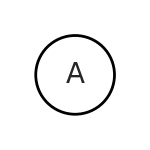

<IPython.core.display.Javascript object>

In [4]:
dag = CausalGraphicalModel(
    nodes=["A"],
    edges=[],
)
pgm = daft.PGM()
coordinates = {
    "A": (0, 1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render()


## Simulate each observation as coming from a different patient

- In all of the data we generate, each row will represent a different appointment.
- In this first example, each row is also a unique patient.

But most patients adhere so we'll set the population parameter for the log-odds to be high.

In [89]:
alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
)
alpha_i[0:5]

array([2.22962666, 1.84680402, 0.47309829, 1.16005507, 3.14306474])

<IPython.core.display.Javascript object>

In [28]:
n_patients = 1000
patient_id = range(n_patients)
a_bar = 1.5  # population average log-odds of adherence
sd_pop = 1  # population SD on log-odds of adherence
alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
)  # use population to get individuals
prob_adhere_i = expit(alpha_i)  # use probability of adherence to get individuals
appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

df_Sim1 = pd.DataFrame(
    {
        "patient_id": patient_id,
        # "alpha":alpha_i,                     # commenting out because this normally wouldn't be in the EHR
        # "prob_adhere":prob_adhere_i,         # commenting out because this normally wouldn't be in the EHR
        "appt_adhere": appt_adhere_i,
    }
)

print(
    "Have a look at 10 randomly sampled values that would be observed from the dataframe"
)
df_Sim1.sample(10)


NameError: name 'expit' is not defined

## Run inference

Simple model, fixed prior, NOT getting an intercept for each patient.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha $$
$$ \alpha_j \sim \text{Normal}(1, 1.5) $$


In [44]:
# intercept only patientid only fixed prior
with pm.Model() as mSim1Ia:

    # prior for patient_id
    a = pm.Normal("a", 1, 1.5)

    # link functionƒ˙
    p = pm.math.invlogit(a)

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim1["appt_adhere"])

    trace_mSim1Ia = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim1Ia = az.summary(trace_mSim1Ia)
    trace_mSim1Ia_df = pm.trace_to_dataframe(trace_mSim1Ia)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [37]:
df_summary_mSim1Ia

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.234,0.074,1.093,1.384,0.001,0.001,3255.0,3255.0,3254.0,5754.0,1.0


<IPython.core.display.Javascript object>

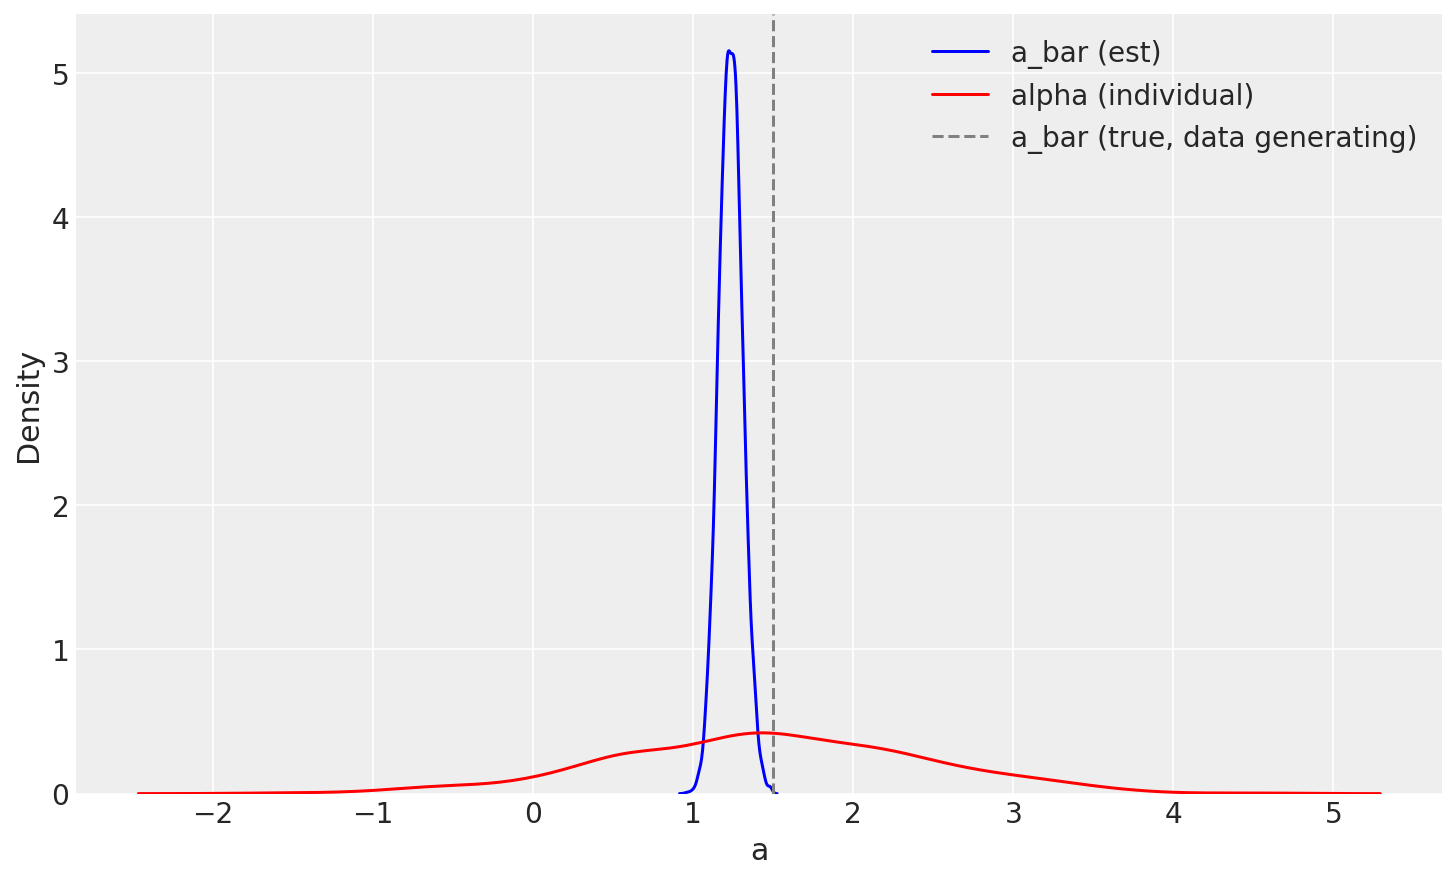

<IPython.core.display.Javascript object>

In [56]:
f, ax0 = plt.subplots(figsize=(10,6))
sns.kdeplot(trace_mSim1Ia_df['a'], color='blue', label='a_bar (est)')
sns.kdeplot(alpha_i, c='red', label='alpha (individual)')

ax0.axvline(a_bar, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.legend()

We can see that the data generating process itself has some stochasticity in terms of what will be the population average. Let's run the simulation five times and estimate.

In [27]:
for i in range(5):

    alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
    )
    prob_adhere_i = expit(alpha_i)
    appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

    df_Sim1_test = pd.DataFrame(
        {
            "patient_id": patient_id,
            "appt_adhere": appt_adhere_i,
        }
    )

    print(i, df_Sim1_test.head())

NameError: name 'a_bar' is not defined

In [115]:
# df_summaries_Sim1 = list()
# trace_posteriors_Sim1 = dict()

for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
    )
    prob_adhere_i = expit(alpha_i)
    appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

    df_Sim1_test = pd.DataFrame(
        {
            "patient_id": patient_id,
            "appt_adhere": appt_adhere_i,
        }
    )

    print(i, df_Sim1_test.head(), end='\n')

    with pm.Model() as mSim1Ia_test:
        a = pm.Normal("a", 1, 1.5)
        p = pm.math.invlogit(a)
        A = pm.Bernoulli("A", p=p, observed=df_Sim1_test["appt_adhere"])
        trace_mSim1Ia_test = pm.sample(
            draws=1000, random_seed=19, return_inferencedata=False, progressbar=False
        )
        df_summary_mSim1Ia_test = az.summary(trace_mSim1Ia_test)
        trace_mSim1Ia_test_df = pm.trace_to_dataframe(trace_mSim1Ia_test)

    print(trace_mSim1Ia_test_df.head(), end='\n\n')
        

 --- loop0 --- 
0    patient_id  appt_adhere
0           0            0
1           1            1
2           2            1
3           3            1
4           4            0


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


          a
0  1.422939
1  1.453402
2  1.356322
3  1.112782
4  1.241105

 --- loop1 --- 
1    patient_id  appt_adhere
0           0            0
1           1            1
2           2            1
3           3            0
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...


          a
0  1.261351
1  1.290758
2  1.365104
3  1.332670
4  1.306148

 --- loop2 --- 
2    patient_id  appt_adhere
0           0            0
1           1            1
2           2            1
3           3            0
4           4            1


INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


          a
0  1.261351
1  1.290758
2  1.365104
3  1.332670
4  1.306148

 --- loop3 --- 
3    patient_id  appt_adhere
0           0            0
1           1            1
2           2            1
3           3            0
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


          a
0  1.261351
1  1.290758
2  1.365104
3  1.332670
4  1.306148

 --- loop4 --- 
4    patient_id  appt_adhere
0           0            0
1           1            1
2           2            1
3           3            0
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


          a
0  1.261351
1  1.290758
2  1.365104
3  1.332670
4  1.306148



<IPython.core.display.Javascript object>

In [116]:
# df_summaries_Sim1 = list()
# trace_posteriors_Sim1 = dict()

for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
    )
    prob_adhere_i = expit(alpha_i)
    appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

    df_Sim1_test = pd.DataFrame(
        {
            "patient_id": patient_id,
            "appt_adhere": appt_adhere_i,
        }
    )

    print(i, df_Sim1_test.head(), end='\n')

    with pm.Model() as mSim1Ia_test:
        a = pm.Normal("a", 1, 1.5)
        p = pm.math.invlogit(a)
        A = pm.Bernoulli("A", p=p, observed=df_Sim1_test["appt_adhere"])
        trace_mSim1Ia_test = pm.sample(
            draws=1000, return_inferencedata=False, progressbar=False
        )
        df_summary_mSim1Ia_test = az.summary(trace_mSim1Ia_test)
        trace_mSim1Ia_test_df = pm.trace_to_dataframe(trace_mSim1Ia_test)

    print(trace_mSim1Ia_test_df.head(), end='\n\n')
        

 --- loop0 --- 
0    patient_id  appt_adhere
0           0            0
1           1            1
2           2            1
3           3            0
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


          a
0  1.433215
1  1.421131
2  1.310899
3  1.310899
4  1.314574

 --- loop1 --- 
1    patient_id  appt_adhere
0           0            1
1           1            1
2           2            1
3           3            0
4           4            0


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


          a
0  1.497634
1  1.425343
2  1.384327
3  1.376532
4  1.416042

 --- loop2 --- 
2    patient_id  appt_adhere
0           0            1
1           1            1
2           2            1
3           3            1
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.881924976908962, but should be close to 0.8. Try to increase the number of tuning steps.


          a
0  1.124687
1  1.179526
2  1.158152
3  1.184133
4  1.151976

 --- loop3 --- 
3    patient_id  appt_adhere
0           0            1
1           1            1
2           2            1
3           3            1
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


          a
0  1.124407
1  1.124407
2  1.179833
3  1.273777
4  1.187689

 --- loop4 --- 
4    patient_id  appt_adhere
0           0            1
1           1            1
2           2            0
3           3            0
4           4            1


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


          a
0  1.311657
1  1.323854
2  1.311904
3  1.345242
4  1.409278



<IPython.core.display.Javascript object>

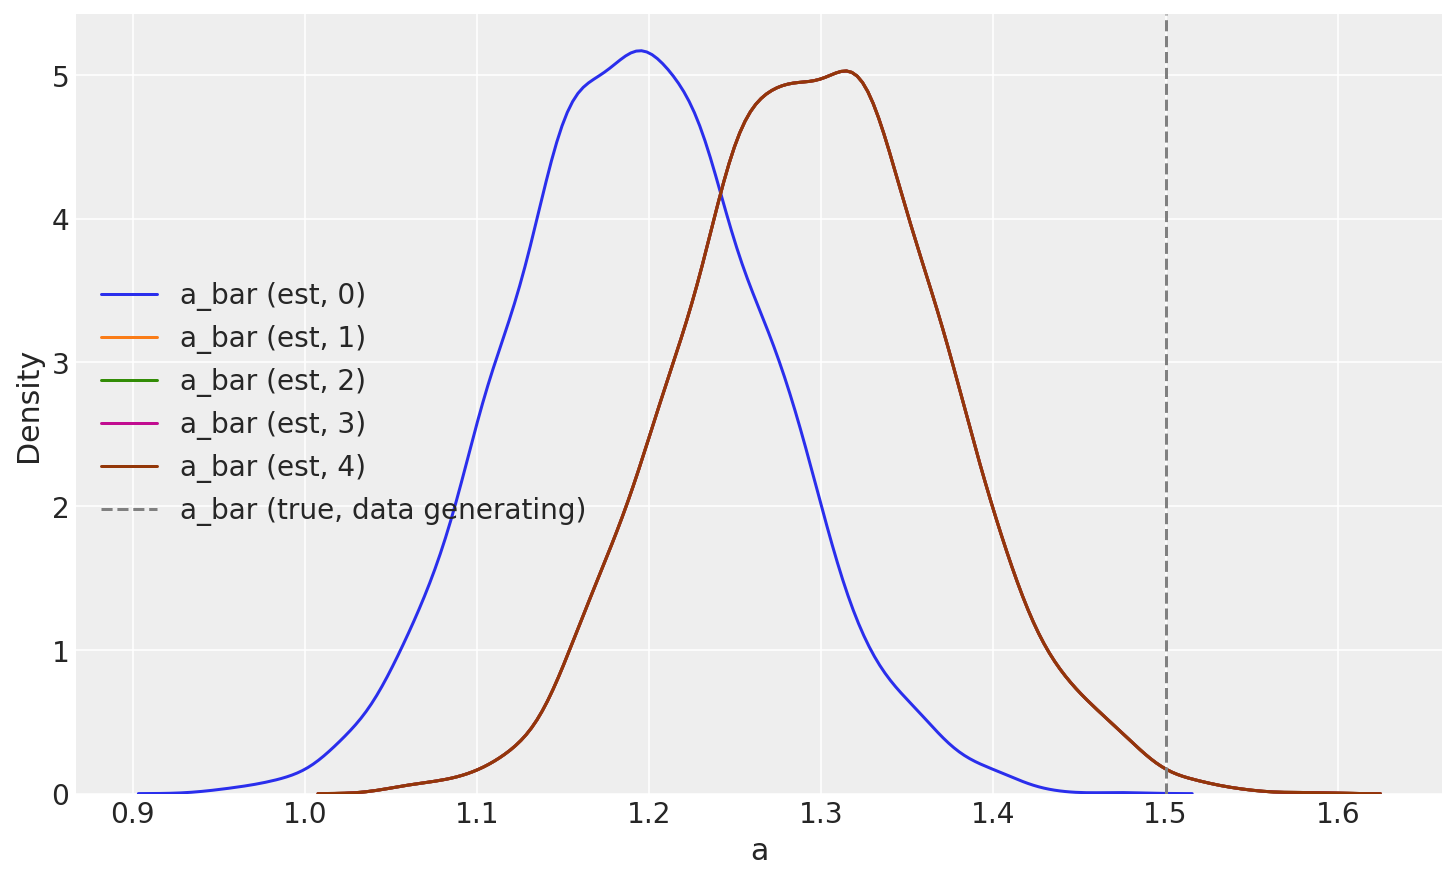

<IPython.core.display.Javascript object>

In [111]:
f, ax0 = plt.subplots(figsize=(10,6))
for i in range(5):
    sns.kdeplot(trace_posteriors_Sim1[i]['a'], label=f'a_bar (est, {i})')
    # trace_posteriors_Sim1[i]['a'].head()

# sns.kdeplot(alpha_i, c='red', label='alpha (individual)')
ax0.axvline(a_bar, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.legend()

In [ ]:
for i in range(5):
    trace_posteriors_Sim1[i]['a']

- The same observation from a smaller number of patients
    - Fixed prior
    - Adaptive prior

# Dataset with different individuals and two characteristics

In [17]:
# create patient ids
pid = np.concatenate([[i] * np.random.randint(1, 10) for i in range(6)])
# assign jobs
jobs = ["teacher", "driver", "cook"]
occ = list()
for id in range(len(pid)):
    job = np.random.choice(jobs)
    occ += [job] * (pid == id).sum()

# assign insurance
ins = ["private", "public"]
ins_type = list()
for id in range(len(pid)):
    ins_type += [np.random.choice(ins)] * (pid == id).sum()

# assign adherence which is a function of occupation and insurance type
b_jobs_sim = {"teacher": 0.75, "driver": 0.5, "cook": 0.25}
b_ins_sim = {"private": 1, "public": 0.5}
mu = np.array([b_jobs_sim[job] for job in occ]) + np.array(
    [b_ins_sim[i] for i in ins_type]
)
a = stats.binom.rvs(n=1, p=expit(mu))


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


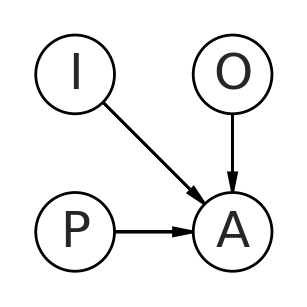

<IPython.core.display.Javascript object>

In [43]:
dag = CausalGraphicalModel(
    nodes=["P", "I", "O", "A"],
    edges=[
        ("P", "A"),
        ("I", "A"),
        ("O", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "P": (0, 0),
    "I": (0, 1),
    "O": (1, 1),
    "A": (1, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render()


In [19]:
df_example = pd.DataFrame(
    {
        "patient_id": pid,
        "occupation": occ,
        "insurance": ins_type,
        "mu": expit(mu),
        "adherence": a,
    }
)
df_example


,patient_id,occupation,insurance,mu,adherence
0,0,cook,private,0.777300,1
1,0,cook,private,0.777300,1
2,0,cook,private,0.777300,0
3,0,cook,private,0.777300,1
4,0,cook,private,0.777300,1
5,1,cook,private,0.777300,1
6,1,cook,private,0.777300,1
7,1,cook,private,0.777300,1
8,2,cook,private,0.777300,0
9,2,cook,private,0.777300,1


<IPython.core.display.Javascript object>

<center>
Model 1
</center>
<br>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{occ}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$

Questions
- Let's assume the estimand is the effect of occupation on adherence. How do I deal with repeated observations from a given patient? Some patients have more appointments than others. Some patients have more appointments than others and so there will be variability in the occupations represented.
    - Put an alpha parameter for each patient id. `Sigma` will be like an encapsulation of all the variation not explained by other parameters. That is model 1b.
- If I had another column (insurance type).
    - Is insurance treated as another cluster or is it a feature of the patient cluster?
- Should I pool treatments?
    - If they have the same prior, then it's usually better to learn the prior from the sample and partially pool.

- When adding features within a cluster, you'd want to use one population prior but expand dimensionality (e.g. using a MVN prior).

Let's look at a few models:
- insurance only (fixed prior)
- patient only (heirarchical)
- patient (heirarchical) and insurance( fixed)
- patient (heirarchical), insurance( f), job(f)

<center>
Model 1
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \gamma_{\text{ins}} $$
$$ \gamma_j \sim \text{Normal}(0, 1.5) $$
<br>

<center>
Model 2
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
<br>

<center>
Model 3
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} + \gamma_{\text{ins}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \gamma_j \sim \text{Normal}(0, 1.5) $$

<br>
<center>
Model 4
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} + \gamma_{\text{ins}} + \delta_{\text{occ}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \gamma_j \sim \text{Normal}(0, 1.5) $$
$$ \delta_k \sim \text{Normal}(0, 1.5) $$

In [22]:
df_example["ins_code"] = pd.Categorical(df_example["insurance"]).codes
df_example.head()


,patient_id,occupation,insurance,mu,adherence,occ_code,ins_code
0,0,cook,private,0.7773,1,0,0
1,0,cook,private,0.7773,1,0,0
2,0,cook,private,0.7773,0,0,0
3,0,cook,private,0.7773,1,0,0
4,0,cook,private,0.7773,1,0,0


<IPython.core.display.Javascript object>

In [23]:
df_example["ins_code"].unique()


array([0, 1], dtype=int8)

<IPython.core.display.Javascript object>

In [25]:
# insurance only
with pm.Model() as mSim1:

    # fixed prior for insurance
    g = pm.Normal("g", 0.0, 1.5, shape=2)

    # link function
    p = pm.math.invlogit(g[df_example["ins_code"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim1 = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g]
INFO:pymc3:NUTS: [g]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [28]:
az.summary(trace_mSim1)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g[0],0.810,0.489,-0.107,1.781,0.009,0.007,2781.0,2382.0,2801.0,2202.0,1.0
g[1],0.915,0.517,-0.072,1.965,0.011,0.009,2162.0,1846.0,2192.0,1914.0,1.0


<IPython.core.display.Javascript object>

In [27]:
df_example.head()


,patient_id,occupation,insurance,mu,adherence,occ_code,ins_code
0,0,cook,private,0.7773,1,0,0
1,0,cook,private,0.7773,1,0,0
2,0,cook,private,0.7773,0,0,0
3,0,cook,private,0.7773,1,0,0
4,0,cook,private,0.7773,1,0,0


<IPython.core.display.Javascript object>

In [29]:
n_patient = len(df_example["patient_id"].unique())

# patientid only, heirarchical
with pm.Model() as mSim2:

    # heirarchical prior for patient_iid
    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)

    # link function
    p = pm.math.invlogit(a[df_example["patient_id"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim2 = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma_a, a_bar]
INFO:pymc3:NUTS: [a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5900351481432856, but should be close to 0.95. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 30 di

<IPython.core.display.Javascript object>

In [30]:
az.summary(trace_mSim2)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.006,0.465,0.113,1.873,0.020,0.014,530.0,530.0,493.0,1113.0,1.02
a[0],1.083,0.581,-0.074,2.232,0.020,0.014,852.0,852.0,747.0,1672.0,1.01
a[1],1.238,0.783,-0.097,2.914,0.028,0.020,787.0,787.0,743.0,1084.0,1.06
a[2],0.781,0.534,-0.339,1.667,0.066,0.051,65.0,56.0,64.0,1322.0,1.05
a[3],1.190,0.763,-0.213,2.632,0.027,0.019,788.0,788.0,727.0,685.0,1.04
a[4],1.056,0.533,-0.073,2.046,0.019,0.013,813.0,813.0,703.0,1738.0,1.01
a[5],0.881,0.520,-0.213,1.807,0.043,0.031,143.0,143.0,129.0,1661.0,1.03
sigma_a,0.483,0.445,0.038,1.320,0.066,0.047,46.0,46.0,15.0,13.0,1.19


<IPython.core.display.Javascript object>

In [36]:
n_patient = len(df_example["patient_id"].unique())

# patientid only, heirarchical
with pm.Model() as mSim2nc:

    # heirarchical prior for patient_id
    a_bar = pm.Normal("a_bar", 0, 1.5)

    z = pm.Normal("z", 0, 1, shape=n_patient)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    # a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma_a)

    # link function
    p = pm.math.invlogit(a[df_example["patient_id"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim2nc = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, a_bar]
INFO:pymc3:NUTS: [sigma_a, z, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [40]:
az.summary(trace_mSim2nc, var_names="~z")


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,0.956,0.458,0.124,1.919,0.009,0.007,2418.0,2043.0,2593.0,1904.0,1.0
sigma_a,0.503,0.468,0.000,1.415,0.011,0.008,1935.0,1935.0,1844.0,2129.0,1.0
a[0],1.037,0.606,-0.064,2.266,0.010,0.008,3845.0,3208.0,4048.0,3359.0,1.0
a[1],1.214,0.796,-0.160,2.858,0.016,0.012,2617.0,2124.0,3276.0,2394.0,1.0
a[2],0.732,0.496,-0.295,1.702,0.007,0.006,4449.0,3610.0,4393.0,2857.0,1.0
a[3],1.167,0.787,-0.237,2.759,0.014,0.011,2963.0,2545.0,3468.0,2833.0,1.0
a[4],0.990,0.510,0.052,2.039,0.008,0.006,4603.0,3882.0,4747.0,3199.0,1.0
a[5],0.828,0.518,-0.136,1.948,0.008,0.006,4729.0,3770.0,4853.0,3220.0,1.0


<IPython.core.display.Javascript object>

In [31]:
# patientid and insurance
with pm.Model() as mSim3:

    # heirarchical prior for patient id
    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)

    # fixed prior for insurance
    g = pm.Normal("g", 0.0, 1.5, shape=2)

    # link function
    p = pm.math.invlogit(a[df_example["patient_id"]] + g[df_example["ins_code"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim3 = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, a, sigma_a, a_bar]
INFO:pymc3:NUTS: [g, a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8909841912079743, b

<IPython.core.display.Javascript object>

In [32]:
az.summary(trace_mSim3)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,0.669,0.901,-1.127,2.473,0.045,0.032,402.0,402.0,400.0,435.0,1.01
a[0],0.780,1.061,-1.396,2.817,0.049,0.035,472.0,472.0,463.0,491.0,1.01
a[1],0.987,1.194,-1.276,3.317,0.056,0.039,460.0,460.0,432.0,456.0,1.01
a[2],0.358,0.985,-1.553,2.294,0.045,0.032,469.0,469.0,467.0,639.0,1.01
a[3],0.937,1.239,-1.509,3.233,0.057,0.040,474.0,474.0,450.0,497.0,1.01
a[4],0.718,1.006,-1.387,2.551,0.046,0.032,484.0,484.0,478.0,556.0,1.01
a[5],0.480,0.993,-1.369,2.519,0.046,0.033,465.0,465.0,462.0,623.0,1.01
g[0],0.350,0.979,-1.520,2.333,0.045,0.032,473.0,473.0,473.0,668.0,1.01
g[1],0.361,0.969,-1.547,2.120,0.044,0.031,474.0,474.0,474.0,1022.0,1.01
sigma_a,0.635,0.544,0.069,1.731,0.030,0.021,330.0,330.0,224.0,185.0,1.01


<IPython.core.display.Javascript object>

In [49]:
df_example["occ_code"] = pd.Categorical(df_example["occupation"]).codes
df_example.head()

n_ins = len(df_example["ins_code"].unique())
n_occ = len(df_example["occ_code"].unique())


<IPython.core.display.Javascript object>

In [52]:
# patientid and insurance
with pm.Model() as mSim4nc:

    # heirarchical prior for patient_id
    a_bar = pm.Normal("a_bar", 0, 1.5)

    z = pm.Normal("z", 0, 1, shape=n_patient)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    # a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma_a)

    # fixed prior for insurance, occupation
    g = pm.Normal("g", 0.0, 1.5, shape=n_ins)
    d = pm.Normal("d", 0.0, 1.5, shape=n_occ)

    # link function
    p = pm.math.invlogit(
        a[df_example["patient_id"]]
        + g[df_example["ins_code"]]
        + d[df_example["occ_code"]]
    )

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim4nc = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, g, sigma_a, z, a_bar]
INFO:pymc3:NUTS: [d, g, sigma_a, z, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

In [56]:
az.compare(
    {
        "ins only": trace_mSim1,
        "patient only, centered": trace_mSim2,
        "patient only, non-centered": trace_mSim2nc,
        "ins + patient": trace_mSim3,
        "ins + patient + occupation": trace_mSim4nc,
    },
    ic="loo",
)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/en

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
"patient only, non-centered",0,-22.374123,2.005743,0.000000,1.000000e+00,2.514161,0.000000,False,log
"patient only, centered",1,-22.463653,2.094190,0.089530,1.375289e-14,2.650797,0.146255,False,log
ins only,2,-22.830595,1.860344,0.456472,0.000000e+00,2.457318,0.375506,False,log
ins + patient,3,-23.358177,3.123838,0.984054,0.000000e+00,2.734794,0.275397,False,log
ins + patient + occupation,4,-23.797574,3.834274,1.423451,0.000000e+00,2.843867,0.537456,False,log


<IPython.core.display.Javascript object>

In [35]:
az.summary(trace_mSim1)["mean"]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


g[0]    0.810
g[1]    0.915
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [34]:
az.summary(trace_mSim2)["mean"]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


a_bar      1.006
a[0]       1.083
a[1]       1.238
a[2]       0.781
a[3]       1.190
a[4]       1.056
a[5]       0.881
sigma_a    0.483
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [33]:
az.summary(trace_mSim3)["mean"]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


a_bar      0.669
a[0]       0.780
a[1]       0.987
a[2]       0.358
a[3]       0.937
a[4]       0.718
a[5]       0.480
g[0]       0.350
g[1]       0.361
sigma_a    0.635
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

# Appendix: Discovery of `pymc` bug

While working on the above post, I discovered a weird bug that I've narrowed down to `pymc` affecting the behavior of functions outside `pymc`.

In [4]:
for i in range(5):
    print(f" --- loop {i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print(test_vals, end='\n\n')

 --- loop 0 --- 
[ 2.78781918  0.20696795 -0.47400206  2.25240217 -0.30937806]

 --- loop 1 --- 
[ 1.50876659  1.8221553  -1.20705219 -0.84927821 -0.8085355 ]

 --- loop 2 --- 
[1.69489455 0.88016133 0.36331002 1.06086608 0.66051196]

 --- loop 3 --- 
[2.00567726 2.87549063 0.62016998 1.34740385 1.00873457]

 --- loop 4 --- 
[ 1.10582285  0.56149565 -0.45163869  1.90397246  3.30575103]



In [5]:
for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=2, scale=1, size=5)
    print(test_vals, end='\n')

    with pm.Model() as mS:
        dummy = pm.Normal("dummy", 0, 0.5)
        trace_test = pm.sample(
            draws=100, random_seed=None, return_inferencedata=False, progressbar=False
        )

        

Only 100 samples in chain.


 --- loop0 --- 
[2.80274505 2.58392764 0.66411826 3.68247745 0.65144538]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop1 --- 
[0.67536384 1.72740423 2.02626766 3.12547542 1.55755134]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8787, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop2 --- 
[1.81629014 1.93631693 2.71444791 1.445055   2.36539921]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8892, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop3 --- 
[1.62564    1.81547907 2.7349837  2.79065454 2.51750992]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop4 --- 
[2.55248326 1.64696853 0.92084814 1.40946193 2.93765212]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.894, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
import numpy as np
import arviz as az

AttributeError: 'MultiTrace' object has no attribute 'head'

In [26]:
for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print("stats.norm.rvs values: ", test_vals, end='\n\n')

    with pm.Model() as m:
        dummy = pm.Normal("dummy", 0, 0.5)
        trace_test = pm.sample(
            draws=100, random_seed=0, return_inferencedata=False, progressbar=False
        )
        print("check pymc sampling with random_seed=0")
        print(trace_test['dummy'][0:5], end='\n')

        print("reset random seed")
        np.random.seed(seed=None)
        

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop0 --- 
stats.norm.rvs values:  [ 0.019048   -0.16396249 -1.36197385  1.33321176  1.46444872]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8853, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.46795611 -0.23220823  0.22529251  0.76628907 -0.71146223]
reset random seed
 --- loop1 --- 
stats.norm.rvs values:  [ 0.85087594  0.77433995  1.17812175  1.17992299 -0.34280457]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8853, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.46795611 -0.23220823  0.22529251  0.76628907 -0.71146223]
reset random seed
 --- loop2 --- 
stats.norm.rvs values:  [ 1.16744827 -1.30708103  2.54481578  1.74631898 -0.66179566]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8853, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.46795611 -0.23220823  0.22529251  0.76628907 -0.71146223]
reset random seed
 --- loop3 --- 
stats.norm.rvs values:  [0.03289028 1.4035661  1.56154409 2.43393023 2.47116958]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8853, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.46795611 -0.23220823  0.22529251  0.76628907 -0.71146223]
reset random seed
 --- loop4 --- 
stats.norm.rvs values:  [0.11886464 0.61403243 0.16277635 1.78810325 1.53460163]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8853, but should be close to 0.8. Try to increase the number of tuning steps.


check pymc sampling with random_seed=0
[-0.46795611 -0.23220823  0.22529251  0.76628907 -0.71146223]
reset random seed


In [21]:
with m:
    trace_test_df = pm.trace_to_dataframe(trace_test)

AttributeError: module 'pymc' has no attribute 'trace_to_dataframe'

array([-0.46795611, -0.23220823,  0.22529251,  0.76628907, -0.71146223])

In [61]:
%watermark -n -u -v -iv -w

Last updated: Fri Apr 08 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy      : 1.6.0
statsmodels: 0.12.2
arviz      : 0.11.1
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pandas     : 1.2.1
matplotlib : 3.3.4
seaborn    : 0.11.1
daft       : 0.1.0
pymc3      : 3.11.0
numpy      : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>